In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

fp = Path("../data/raw/ae_timeseries.csv")

# 1) Read raw with NO header (since the real header is in-row)
raw = pd.read_csv(fp, header=None)

# 2) Find the row that contains the true headers (the first column should be 'Period')
#    In your pasted preview, row 2 looked like:
#    ['Period', 'Type 1 ...', 'Type 2 ...', 'Type 3 ...', 'Total Attendances', ...]
def find_header_index(df):
    for i in range(min(50, len(df))):  # search first 50 rows
        first_cell = str(df.iloc[i, 0]).strip().lower()
        if first_cell == "period":
            return i
    raise ValueError("Could not find header row with 'Period' in first column.")

hdr_idx = find_header_index(raw)

# 3) Rebuild dataframe with proper headers
headers = raw.iloc[hdr_idx].tolist()
df = raw.iloc[hdr_idx + 1 : ].copy()
df.columns = headers

# 4) Keep only the Period + Total Attendances columns (names vary slightly over time)
#    We’ll search for a column that looks like "Total Attendances".
period_col = "Period"
cand_total_cols = [c for c in df.columns if isinstance(c, str) and "total" in c.lower() and "attend" in c.lower()]
if not cand_total_cols:
    r


        Date  Total Attendances
4 2010-08-01            1752381
5 2010-09-01            1756268
6 2010-10-01            1801348
7 2010-11-01            1651027
8 2010-12-01            1737741 

          Date  Total Attendances
179 2025-03-01            2389064
180 2025-04-01            2295820
181 2025-05-01            2395886
182 2025-06-01            2350478
183 2025-07-01            2407884 

Rows: 180 Date range: 2010-08-01 00:00:00 → 2025-07-01 00:00:00


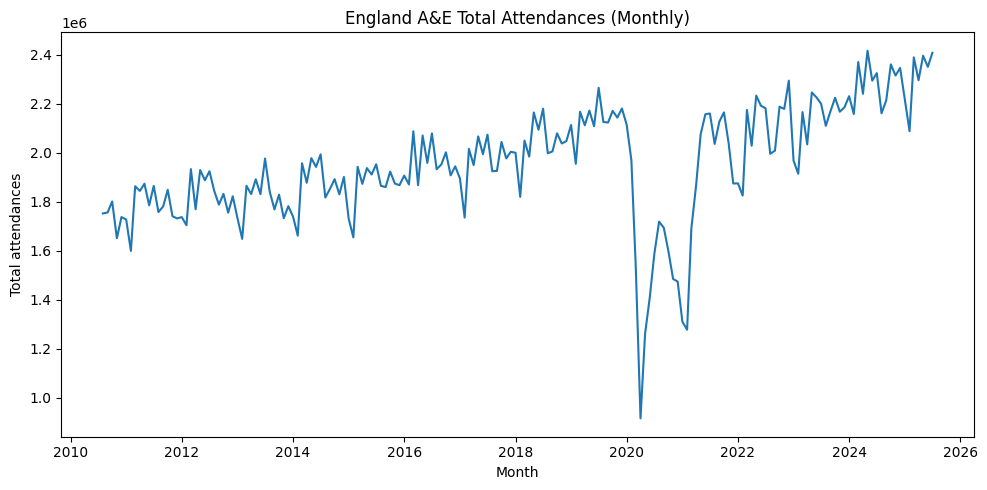

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

fp = Path("../data/raw/ae_timeseries.csv")

# 1) Read raw with NO header (since the real header is in-row)
raw = pd.read_csv(fp, header=None)

# 2) Find the row that contains the true headers (the first column should be 'Period')
#    In your pasted preview, row 2 looked like:
#    ['Period', 'Type 1 ...', 'Type 2 ...', 'Type 3 ...', 'Total Attendances', ...]
def find_header_index(df):
    for i in range(min(50, len(df))):  # search first 50 rows
        first_cell = str(df.iloc[i, 0]).strip().lower()
        if first_cell == "period":
            return i
    raise ValueError("Could not find header row with 'Period' in first column.")

hdr_idx = find_header_index(raw)

# 3) Rebuild dataframe with proper headers
headers = raw.iloc[hdr_idx].tolist()
df = raw.iloc[hdr_idx + 1 : ].copy()
df.columns = headers

# 4) Keep only the Period + Total Attendances columns (names vary slightly over time)
#    We’ll search for a column that looks like "Total Attendances".
period_col = "Period"
cand_total_cols = [c for c in df.columns if isinstance(c, str) and "total" in c.lower() and "attend" in c.lower()]
if not cand_total_cols:
    raise ValueError(f"Couldn't find a 'Total Attendances' column. Columns: {df.columns.tolist()}")
total_col = cand_total_cols[0]

# 5) Clean numeric (remove commas/percent, coerce to float)
def to_num(s):
    if pd.isna(s):
        return None
    s = str(s).replace(",", "").replace("%", "").strip()
    return pd.to_numeric(s, errors="coerce")

df[total_col] = df[total_col].map(to_num)

# 6) Parse Period → datetime
#    NHS uses formats like '10-Aug' meaning 2010-Aug. We’ll try %y-%b first, then a few fallbacks.
def parse_period(x):
    x = str(x).strip()
    for fmt in ("%y-%b", "%Y-%b", "%b-%y", "%b-%Y"):
        try:
            return pd.to_datetime(x, format=fmt)
        except Exception:
            pass
    # If the value is truly not a month (e.g., 'Operational standard'), return NaT
    return pd.NaT

df["Date"] = df[period_col].map(parse_period)

# 7) Keep only valid rows
ts = df[["Date", total_col]].dropna().copy()
ts = ts.sort_values("Date")
ts = ts[ts[total_col] > 0]  # drop any non-positive artifacts

print(ts.head(), "\n")
print(ts.tail(), "\n")
print("Rows:", len(ts), "Date range:", ts["Date"].min(), "→", ts["Date"].max())

# 8) Plot sanity chart
plt.figure(figsize=(10,5))
plt.plot(ts["Date"], ts[total_col])
plt.title("England A&E Total Attendances (Monthly)")
plt.xlabel("Month")
plt.ylabel("Total attendances")
plt.tight_layout()
plt.show()
